In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import sys
sys.path.append("../../")
from src.util import operators
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_nonlinear as compute_exp_val_nonlinear
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_linear as compute_exp_val_linear
from src.util import bath_correlation_function
from src.util import debye_spectral_density  
from src.homps import homps
from src.util import operators

In [3]:
# Parameters for the spin-boson model
epsilon = 2.0
delta = -2.0
# Parameters for the Debye spectral density
beta = 50.0
T = 1/beta
gamma = 5.0
eta = 0.5
# operators
sigma_x, sigma_z, eye = operators.generate_physical_operators()
L = sigma_z
h = operators.generate_spin_boson_hamiltonian(delta=delta, epsilon=epsilon)
# time window
duration = 30

# Convergence of the BCF

In [7]:
g_compare, w_compare = debye_spectral_density.get_debye_coefficients(10000, T, gamma, eta)

In [24]:
N_steps = 1000
taus = np.linspace(0, duration, N_steps)
N_terms = [5, 10, 13, 20]
alphas = np.empty((len(N_terms), N_steps), dtype=complex)
for i, N in enumerate(N_terms):
    g, w = debye_spectral_density.get_debye_coefficients(N, T, gamma, eta, mode='pade')
    alphas[i, :] = bath_correlation_function.alpha(taus, g, w)
alphas_compare = bath_correlation_function.alpha(taus, g_compare, w_compare)

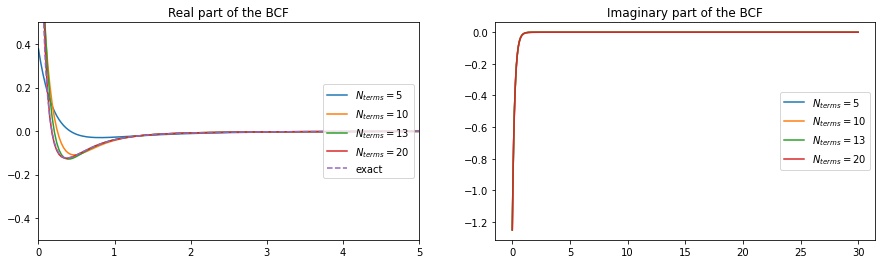

In [25]:
figure, axarray = plt.subplots(1, 2, figsize=(15, 4))
for i, N in enumerate(N_terms):
    axarray[0].plot(taus, np.real(alphas[i, :]), label="$N_{terms} = "+str(N)+"$")
    axarray[1].plot(taus, np.imag(alphas[i, :]), label="$N_{terms} = "+str(N)+"$")
axarray[0].plot(taus, np.real(alphas_compare), "--", label="exact")
axarray[0].legend(loc="right")
axarray[0].set_title("Real part of the BCF")
axarray[0].set_xlim(0, 5)
axarray[0].set_ylim(-0.5, 0.5)
axarray[1].legend(loc="right")
axarray[1].set_title("Imaginary part of the BCF")
plt.show()

# HOMPS: Convergence in N_steps (without noise)

In [41]:
N_steps_list = [500, 1000, 1500, 2000, 6000]
N_trunc = 9
N_terms = 15
g, w = debye_spectral_density.get_debye_coefficients(N_terms, T, gamma, eta, mode='pade')

In [42]:
options = {
    'linear' : False,
    'use_noise' : False,
    'chi_max' : 10,
    'eps' : 1.e-3,
    'method' : 'RK4',
}

In [43]:
psis_N_steps = []

for N_steps in N_steps_list:
    print("Computing N_steps =", N_steps)
    start = time.time()
    my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
    psis_N_steps.append(my_homps.compute_realizations(1))
    end = time.time()
    print("took", end-start, "seconds.")

Computing N_steps = 500
took 15.92944049835205 seconds.
Computing N_steps = 1000
took 35.37481331825256 seconds.
Computing N_steps = 1500
took 78.53362798690796 seconds.
Computing N_steps = 2000
took 98.35010051727295 seconds.
Computing N_steps = 6000
took 186.31661462783813 seconds.


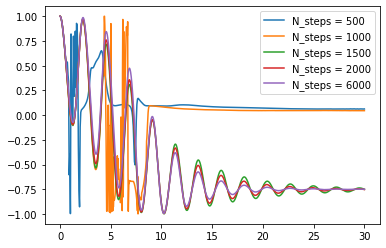

In [44]:
for i, N_steps in enumerate(N_steps_list):
    sigma_zs = compute_exp_val_nonlinear(psis_N_steps[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="N_steps = "+str(N_steps))
plt.legend()
plt.show()

# HOMPS: Convergence in N_trunc (without noise)

In [46]:
N_steps = 2000
N_trunc_list = [2, 5, 9, 10, 15]
N_terms = 15
g, w = debye_spectral_density.get_debye_coefficients(N_terms, T, gamma, eta, mode='pade')

In [49]:
options = {
    'linear' : False,
    'use_noise' : False,
    'chi_max' : 10,
    'eps' : 1.e-3,
    'method' : 'RK4',
}

In [50]:
psis_N_trunc = []

for N_trunc in N_trunc_list:
    print("Computing N_trunc =", N_trunc)
    start = time.time()
    my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
    psis_N_trunc.append(my_homps.compute_realizations(1))
    end = time.time()
    print("took", end-start, "seconds.")

Computing N_trunc = 2
took 34.15470790863037 seconds.
Computing N_trunc = 5
took 55.12074303627014 seconds.
Computing N_trunc = 9
took 96.628342628479 seconds.
Computing N_trunc = 10
took 112.2349328994751 seconds.
Computing N_trunc = 15
took 168.4170458316803 seconds.


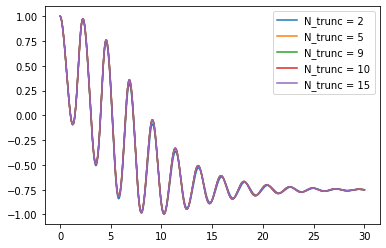

In [51]:
for i, N_trunc in enumerate(N_trunc_list):
    sigma_zs = compute_exp_val_nonlinear(psis_N_trunc[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="N_trunc = "+str(N_trunc))
plt.legend()
plt.show()

# HOMPS: Convergence in N_trunc (with noise)

In [61]:
N_steps = 2000
N_trunc_list = [2, 5, 9, 10, 15]
N_terms = 15
g, w = debye_spectral_density.get_debye_coefficients(N_terms, T, gamma, eta, mode='pade')

In [62]:
options = {
    'linear' : False,
    'use_noise' : True,
    'chi_max' : 10,
    'eps' : 1.e-5,
    'method' : 'RK4'
}
my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc_list[0], options)
zts_debug = my_homps.generator.sample_process()

In [63]:
psis_N_trunc = []

for N_trunc in N_trunc_list:
    print("Computing N_trunc =", N_trunc)
    start = time.time()
    my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
    psis_N_trunc.append(my_homps.compute_realizations(1, zts_debug=zts_debug))
    end = time.time()
    print("took", end-start, "seconds.")

Computing N_trunc = 2
took 71.12234330177307 seconds.
Computing N_trunc = 5
took 248.1877224445343 seconds.
Computing N_trunc = 9
took 607.6086223125458 seconds.
Computing N_trunc = 10
detected keyboard interrupt.
took 116.74727582931519 seconds.
Computing N_trunc = 15
detected keyboard interrupt.
took 1.6120326519012451 seconds.


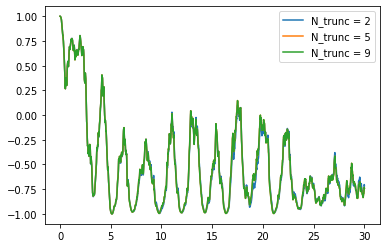

In [68]:
for i, N_trunc in enumerate(N_trunc_list[:3]):
    sigma_zs = compute_exp_val_nonlinear(psis_N_trunc[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="N_trunc = "+str(N_trunc))
plt.legend()
plt.show()

# HOMPS: Convergence in eps (without noise)

In [118]:
N_steps = 500
N_trunc = 9
eps_list = [1.e-3, 1.e-4, 1.e-5, 1.e-6]

In [119]:
options = {
    'linear' : False,
    'use_noise' : False,
    'chi_max' : 10,
    'eps' : 1.e-3,
    'method' : 'RK4',
    'use_precise_svd' : False,
}

In [120]:
psis_eps = []
average_bond_dims = []

for eps in eps_list:
    print("Computing eps =", eps)
    start = time.time()
    options['eps'] = eps
    my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
    psis_eps.append(my_homps.compute_realizations(1, collect_debug_info=True))
    average_bond_dims.append(my_homps.debug_info['average_bond_dim'][0])
    end = time.time()
    print("took", end-start, "seconds.")

Computing eps = 0.001
took 6.705924034118652 seconds.
Computing eps = 0.0001
took 15.85446810722351 seconds.
Computing eps = 1e-05
took 25.519872188568115 seconds.
Computing eps = 1e-06
took 47.39425086975098 seconds.


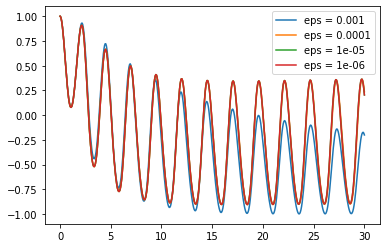

In [121]:
for i, eps in enumerate(eps_list):
    sigma_zs = compute_exp_val_nonlinear(psis_eps[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="eps = "+str(eps))
plt.legend()
plt.show()

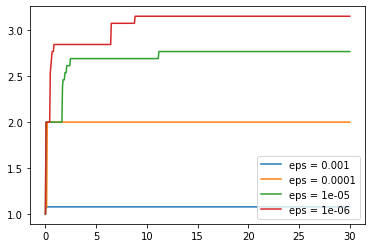

In [122]:
for i, eps in enumerate(eps_list):
    plt.plot(np.linspace(0, duration, N_steps), average_bond_dims[i], label="eps = "+str(eps))
plt.legend()
plt.show()

# HOMPS: Convergence in eps (with noise)

In [26]:
N_steps = 500
N_trunc = 9
eps_list = [1.e-3, 1.e-4, 1.e-5, 1.e-6]

In [27]:
options = {
    'linear' : False,
    'use_noise' : True,
    'chi_max' : 10,
    'eps' : 1.e-3,
    'method' : 'RK4',
    'use_precise_svd' : False,
    'g_noise' : g_noise,
    'w_noise' : w_noise,
}

In [28]:
my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
zts_debug = my_homps.generator.sample_process()

In [17]:
psis_eps = []
average_bond_dims = []

for eps in eps_list:
    print("Computing eps =", eps)
    start = time.time()
    options['eps'] = eps
    my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
    psis_eps.append(my_homps.compute_realizations(1, zts_debug=zts_debug, collect_debug_info=True))
    average_bond_dims.append(my_homps.debug_info['average_bond_dim'][0])
    end = time.time()
    print("took", end-start, "seconds.")

Computing eps = 0.001
took 19.605241298675537 seconds.
Computing eps = 0.0001
took 40.06075429916382 seconds.
Computing eps = 1e-05
took 52.48275876045227 seconds.
Computing eps = 1e-06
took 71.77229022979736 seconds.


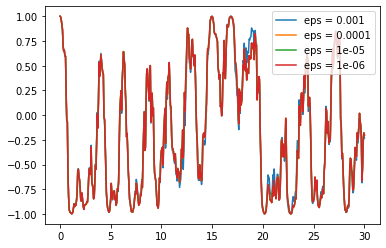

In [18]:
for i, eps in enumerate(eps_list):
    sigma_zs = compute_exp_val_nonlinear(psis_eps[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="eps = "+str(eps))
plt.legend()
plt.show()

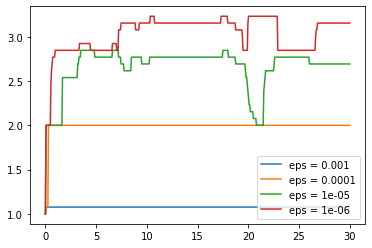

In [223]:
for i, eps in enumerate(eps_list):
    plt.plot(np.linspace(0, duration, N_steps), average_bond_dims[i], label="eps = "+str(eps))
plt.legend()
plt.show()

To make sure, one can choose 1.e-6, but 1.e-5 and 1.e-4 seem to be well converged as well.
For now, we will choose eps=1.e-5. Theres no point in trying higher values for chi_max, since the average bond dimension is below 5 even for eps=1.e-6.

# HOMPS: Convergence in chi_max (with noise)

In [29]:
N_steps = 500
N_trunc = 9
chi_max_list = [10, 20, 30]

In [30]:
options = {
    'linear' : False,
    'use_noise' : True,
    'chi_max' : 10,
    'eps' : 1.e-6,
    'method' : 'RK4',
    'use_precise_svd' : False,
    'g_noise' : g_noise,
    'w_noise' : w_noise,
}

In [31]:
my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
zts_debug = my_homps.generator.sample_process()

In [32]:
psis_chi_max = []
average_bond_dims = []

for chi_max in chi_max_list:
    print("Computing chi_max =", chi_max)
    start = time.time()
    options['chi_max'] = chi_max
    my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
    psis_chi_max.append(my_homps.compute_realizations(1, zts_debug=zts_debug, collect_debug_info=True))
    average_bond_dims.append(my_homps.debug_info['average_bond_dim'][0])
    end = time.time()
    print("took", end-start, "seconds.")

Computing chi_max = 10
took 45.037307262420654 seconds.
Computing chi_max = 20
took 37.86737656593323 seconds.
Computing chi_max = 30
took 37.09593176841736 seconds.


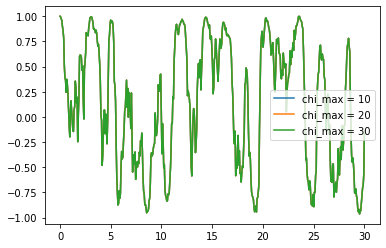

In [34]:
for i, chi_max in enumerate(chi_max_list):
    sigma_zs = compute_exp_val_nonlinear(psis_chi_max[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="chi_max = "+str(chi_max))
plt.legend()
plt.show()

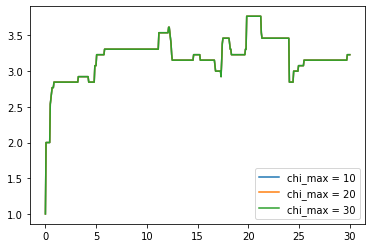

In [35]:
for i, chi_max in enumerate(chi_max_list):
    plt.plot(np.linspace(0, duration, N_steps), average_bond_dims[i], label="chi_max = "+str(chi_max))
plt.legend()
plt.show()

Converged.

# HOMPS: Convergence in N_terms (without noise)

In [55]:
N_steps = 2000
N_trunc = 9
N_terms_list = [10, 15, 20]

In [56]:
options = {
    'linear' : False,
    'use_noise' : False,
    'chi_max' : 10,
    'eps' : 1.e-3,
    'method' : 'RK4',
}

Computing N_terms = 10
took 60.555630922317505 seconds.
bond dims at the last iteration:
[2. 4. 2. 2. 1. 1. 1. 1. 1. 1.]


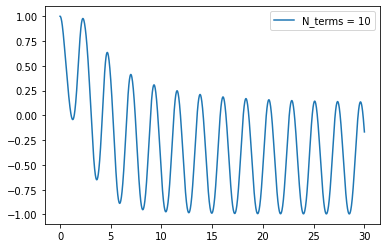

Computing N_terms = 15
took 92.13174653053284 seconds.
bond dims at the last iteration:
[2. 3. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1.]


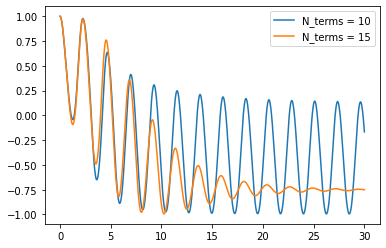

Computing N_terms = 20
took 147.58490228652954 seconds.
bond dims at the last iteration:
[2. 3. 3. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1.]


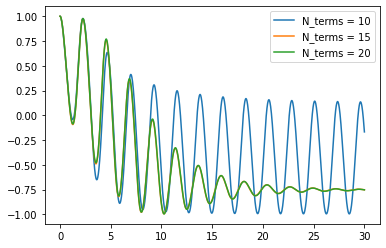

In [57]:
psis_N_terms = []
bond_dims = []

def plot_progress(i):
    print("bond dims at the last iteration:")
    print(bond_dims[-1][-1])
    for j in range(i+1):
        sigma_zs = compute_exp_val_nonlinear(psis_N_terms[j], sigma_z)
        plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="N_terms = "+str(N_terms_list[j]))
    plt.legend()
    plt.show()

for i, N_terms in enumerate(N_terms_list):
    print("Computing N_terms =", N_terms)
    start = time.time()
    g, w = debye_spectral_density.get_debye_coefficients(N_terms, T, gamma, eta, mode='pade')
    my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
    psis_N_terms.append(my_homps.compute_realizations(1, collect_debug_info=True))
    bond_dims.append(my_homps.debug_info['bond_dims'][0])
    end = time.time()
    print("took", end-start, "seconds.")
    plot_progress(i)

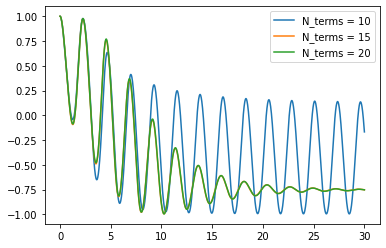

In [59]:
for i, N_terms in enumerate(N_terms_list):
    sigma_zs = compute_exp_val_nonlinear(psis_N_terms[i], sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="N_terms = "+str(N_terms))
plt.legend()
plt.show()